In [36]:
import os

import pandas as pd

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
timing_dir = '../eval/llm_performance'
files = [os.path.abspath(os.path.join(timing_dir, f)) for f in os.listdir(timing_dir) if ('.json' in f)]
# files

In [38]:
results = []

for file in files:
    with open(file, "r") as f:
        name = file.split("/")[-1].split(".")[0]
        meta_raw = name.split("_imdb_")[1].split("_")
        keys = meta_raw[0::2]
        values = meta_raw[1::2]

        meta = {k: int(v) for k, v in zip(keys, values)}
        
        content = json.loads(f.read())
        prediction = content['children'][0]['children'][0]
        pred_info = prediction['extra_info'].split('|')[1:]
        total = 0
        for i in pred_info:
            kv = i.split(":")
            if (kv[0] in ['load', 'move', 'predict', 'move_rev']):
                total += int(kv[1])
            meta[kv[0]] = int(kv[1])
        meta['total_time'] = total / (1000 * 1000)
        meta['acc'] = float(meta['correct']) / meta['total']
        results.append(meta)

results = pd.DataFrame(results)
results.head()

,n,lmt,bs,run,intratc,correct,load,move,move_rev,predict,total,total_time,acc
0,1024,128,256,3,16,871,788891,344155,63,19931665,1024,21.064774,0.850586
1,1024,128,1,2,64,871,880902,744872,113,29879591,1024,31.505478,0.850586
2,1024,128,256,2,32,871,828032,350573,28,18745255,1024,19.923888,0.850586
3,1024,256,1024,3,16,918,806467,378120,29,63933902,1024,65.118518,0.896484
4,1024,512,4,3,64,931,811419,565875,76,139867187,1024,141.244557,0.909180


## Batch Size vs LLM Max Tokens

#### 100 rows

In [39]:
out = results[results['n'] == 1024]
out = out.loc[:, ['bs', 'lmt', 'total_time']].groupby(['bs', 'lmt']).mean().reset_index()
out = out.pivot(index="bs", columns="lmt", values="total_time")

In [40]:
out

lmt,128,256,384,512
bs,,,,
1,25.415095,51.699607,95.345618,153.330542
4,22.939660,51.396314,91.406724,144.709913
16,22.067578,50.166892,92.188766,157.852719
64,24.115007,55.211009,99.308926,164.647978
256,26.111002,61.595039,120.574983,204.970708
1024,27.525370,79.135709,151.380833,234.354848


Text(0.5, 1.0, 'Performance on all tuples (sec)')

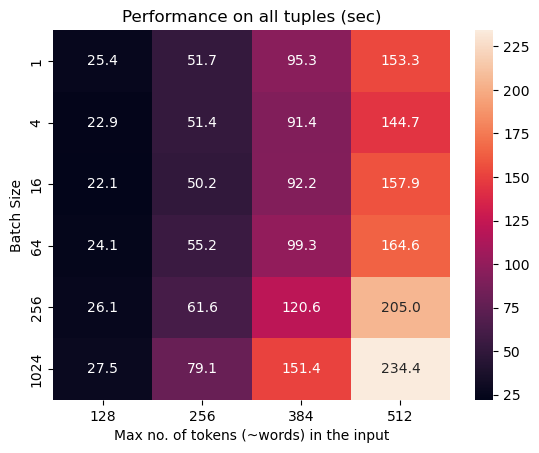

In [41]:
sns.heatmap(data=out, annot=True, fmt=".1f")
plt.xlabel('Max no. of tokens (~words) in the input')
plt.ylabel('Batch Size')
plt.title('Performance on all tuples (sec)')

#### Accuracy

In [42]:
out = results[results['n'] == 1024]
out = out.loc[:, ['bs', 'lmt', 'acc']].groupby(['bs', 'lmt']).mean().reset_index()
out = out.pivot(index="bs", columns="lmt", values="acc")

Text(0.5, 1.0, 'Accuracy on all tuples (sec)')

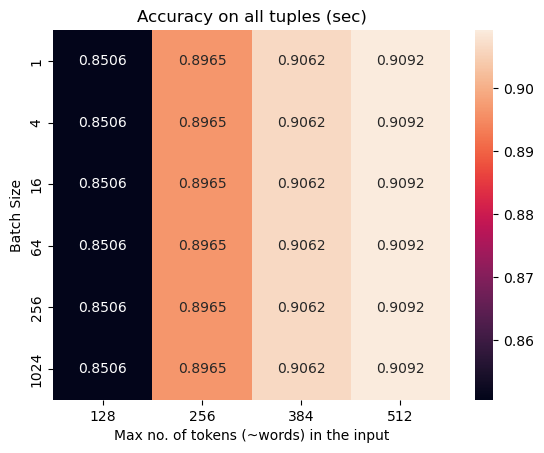

In [43]:
sns.heatmap(data=out, annot=True, fmt=".4f")
plt.xlabel('Max no. of tokens (~words) in the input')
plt.ylabel('Batch Size')
plt.title('Accuracy on all tuples (sec)')

In [44]:
results[(results['n'] == 1000) & (results['lmt'] == 512)].sort_values('total')

,n,lmt,bs,run,intratc,correct,load,move,move_rev,predict,total,total_time,acc
